In [1]:
import os
import json
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedGroupKFold
import matplotlib.pyplot as plt
%matplotlib inline
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.FATAL)

In [2]:
# function to return the cv splits by index

def fetch_cv_indicies(X, y, g):
    sgkf = StratifiedGroupKFold(n_splits=10)
    sgkf.get_n_splits(X, y)
    cv_splits = sgkf.split(X, y, g)
        
    return cv_splits


In [3]:
def load_data(data_path, target_labels):
    
    with open(data_path, "r") as fp:
        data = json.load(fp)
        
    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data[target_labels]).astype(int)
    g = np.array(data['fold_label'])

    print("Data successfully loaded!")

    return  X, y, g

In [4]:
mfcc_path = '../data/processed/13_mfcc_5_train.json'

In [5]:
# load data
X, y, g = load_data(data_path=mfcc_path, target_labels='class_label')

Data successfully loaded!


In [6]:
def build_model():
    model = keras.Sequential([

        # input layer
        keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),
        keras.layers.BatchNormalization(),

        # 1st dense layer
        keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.4),

        # 2nd dense layer
        keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.4),

        # output layer
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimiser,
                  loss='BinaryCrossentropy',
                  metrics=['binary_accuracy'])
    
    return model

In [7]:
iters = 0
scores = []
devs = []
cum_ave = []

while iters < 50:

    # evaluate model with cv splits
    build = build_model()
    model = KerasClassifier(model=build, batch_size=260, epochs=100, random_state=0, verbose=0)

    results = cross_validate(model, X, y, cv=fetch_cv_indicies(X, y, g), n_jobs=-1)
    print(f"{iters+1}) Acc: %.2f%% (%.2f%%)" % (results['test_score'].mean()*100, results['test_score'].std()*100))

    scores.append(results['test_score'].mean()*100)
    devs.append(results['test_score'].std()*100)
    cum_ave.append(np.array(scores).mean())
    
    iters += 1
    
print(f"After {iters} iterations) Baseline: %.2f%% (%.2f%%)" % (np.array(scores).mean(), np.array(devs).mean()))


1) Acc: 96.69% (2.49%)
2) Acc: 95.84% (4.23%)
3) Acc: 96.02% (3.81%)
4) Acc: 95.89% (5.00%)
5) Acc: 96.05% (3.62%)
6) Acc: 96.86% (1.83%)
7) Acc: 96.75% (2.06%)
8) Acc: 96.08% (4.48%)
9) Acc: 96.81% (1.87%)
10) Acc: 96.53% (3.26%)
11) Acc: 95.98% (4.24%)
12) Acc: 96.87% (2.01%)
13) Acc: 97.07% (1.80%)
14) Acc: 96.79% (3.12%)
15) Acc: 96.16% (3.58%)
16) Acc: 96.55% (2.43%)
17) Acc: 96.60% (2.36%)
18) Acc: 97.17% (1.46%)
19) Acc: 96.84% (2.48%)
20) Acc: 96.56% (2.99%)
21) Acc: 96.75% (2.27%)
22) Acc: 96.26% (3.26%)
23) Acc: 96.81% (2.03%)
24) Acc: 96.42% (3.73%)
25) Acc: 96.92% (2.60%)
26) Acc: 97.02% (2.09%)
27) Acc: 96.57% (3.02%)
28) Acc: 96.92% (1.93%)
29) Acc: 97.25% (1.80%)
30) Acc: 97.17% (1.97%)
31) Acc: 95.78% (3.76%)
32) Acc: 97.12% (2.24%)
33) Acc: 96.75% (2.19%)
34) Acc: 96.81% (2.39%)
35) Acc: 97.05% (1.48%)
36) Acc: 96.75% (2.41%)
37) Acc: 97.11% (1.72%)
38) Acc: 96.75% (2.08%)
39) Acc: 96.67% (2.01%)
40) Acc: 96.50% (4.30%)
41) Acc: 96.44% (3.01%)
42) Acc: 96.27% (3.48%)
4

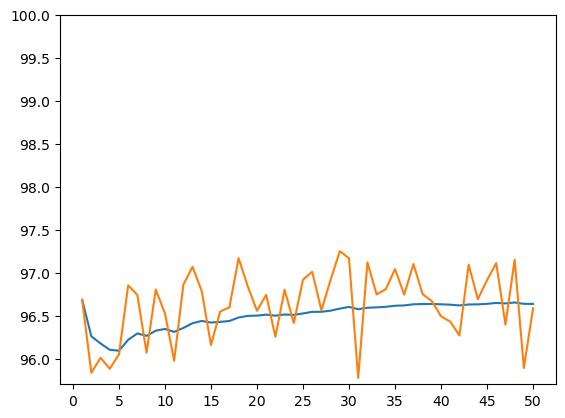

In [8]:
# plot the cumulative average of accuracy
x = range(1, len(scores)+1, 1)
y_cum = cum_ave
plt.plot(x, y_cum)
plt.plot(x, scores)
plt.xticks(range(0, len(scores)+1, 5))
plt.ylim(top=100)
plt.show()

In [9]:
print(f"\nBaseline after {iters} iterations of 10-fold cross-validation:\n\nMean Accuracy: %.2f%% (%.2f%%)\nMean St Dev: (%.2f%%)" % (np.array(scores).mean(), np.array(scores).std(), np.array(devs).mean()))


Baseline after 50 iterations of 10-fold cross-validation:

Mean Accuracy: 96.64% (0.40%)
Mean St Dev: (2.72%)
